In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits import mplot3d
from numpy.random import normal, choice, rand, beta, binomial, randint, dirichlet
from numpy.linalg import matrix_rank, norm, svd, eig, qr
from scipy.linalg import pinv
from scipy import interpolate
from scipy.stats import entropy
import tensorly as tl
#def pinv(x): return pinv2(x, rcond=10 * np.finfo(float).eps)
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
import scipy.io
mat = scipy.io.loadmat('./data/Cardiac_DE_2.mat')

In [3]:
A = mat['X']
N = np.array(A.shape)

In [4]:
N

array([256, 176, 160])

In [5]:
# matrix unfoldings
A0 = A.reshape(N[0],N[1]*N[2]) # 0 1 2
tmp = np.moveaxis(A,0,2) # 1 2 0
A1 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
tmp = np.moveaxis(A,2,0) # 2 0 1
A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])

In [6]:
def HOSVD_rank(A):
    A1 = A.reshape(A.shape[0],A.shape[1]*A.shape[2]) # 1 2 3
    tmp = np.moveaxis(A,0,2) # 2 3 1
    A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    tmp = np.moveaxis(A,2,0) # 3 1 2
    A3 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    U1, s1, V1 = svd(A1,full_matrices=False)
    U2, s2, V2 = svd(A2,full_matrices=False)
    U3, s3, V3 = svd(A3,full_matrices=False)
    
    scree1 = []
    scree2 = []
    scree3 = []
    for r in range(s1.shape[0]):
        print(r,end='\r')
        scree1.append(norm(s1[r+1:])**2 / norm(A1)**2)
        if norm(s1[r+1:])**2 / norm(A1)**2 < 1e-7 :
                break
    for r in range(s2.shape[0]):
        print(r,end='\r')
        scree2.append(norm(s2[r+1:])**2 / norm(A2)**2)
        if norm(s2[r+1:])**2 / norm(A2)**2 < 1e-7 :
                break
    for r in range(s3.shape[0]):
        print(r,end='\r')
        scree3.append(norm(s3[r+1:])**2 / norm(A3)**2)   
        if norm(s3[r+1:])**2 / norm(A3)**2 < 1e-7 :
                break
                
    return [scree1, scree2, scree3]

In [7]:
scree = HOSVD_rank(A)

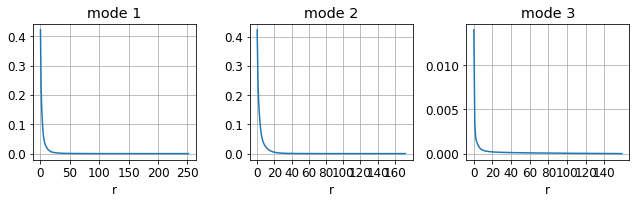

In [8]:
plt.rcParams.update({'font.size': 12})
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(scree[0])
ax[0].set_title('mode 1')
ax[0].set_xlabel('r')
ax[0].set_xticks(np.arange(0, N[0], 50))
ax[0].grid()

ax[1].plot(scree[1])
ax[1].set_title('mode 2')
ax[1].set_xlabel('r')
ax[1].set_xticks(np.arange(0, N[1], 20))
ax[1].grid()

ax[2].plot(scree[2])
ax[2].set_title('mode 3')
ax[2].set_xlabel('r')
ax[2].set_xticks(np.arange(0, N[2], 20))
ax[2].grid()
plt.tight_layout()
#plt.savefig('plots/cardiac_screes.png',dpi=300)
plt.show()

In [9]:
r = np.array([20,20,5])

In [10]:
errRSCT = []
timeRSCT = []
for i in range(100):
    print(f'{i}/100',end='\r')
    _, err, t = Random_SketchyCoreTucker(A,r,300)
    errRSCT.append(err)
    timeRSCT.append(t)

NameError: name 'Random_SketchyCoreTucker' is not defined

In [41]:
errPS = []
timePS = []
for i in range(100):
    print(f'{i}/100',end='\r')
    _, err, m, t = pgSketchyCoreTucker(A,r,10,10,300)
    errPS.append(err)
    timePS.append(t)

In [58]:
errPS2 = []
timePS2 = []
for i in range(100):
    print(f'{i}/100',end='\r')
    _, err, m, t = pgSketchyCoreTuckerPermute(A,r,10,10,300)
    errPS2.append(err)
    timePS2.append(t)

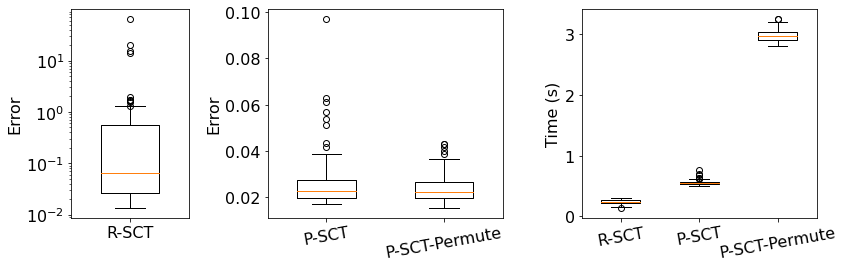

In [48]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,3,figsize=[12,4],gridspec_kw={'width_ratios': [1, 2, 2]})
ax[0].boxplot([errRSCT],widths=0.5)
ax[0].set_yscale('log')
ax[0].set_xticklabels(['R-SCT'])
ax[0].set_ylabel('Error')
ax[1].boxplot([errPS,errPS2],widths=0.5)
ax[1].set_xticklabels(['P-SCT','P-SCT-Permute'],rotation=10)
ax[1].set_ylabel('Error')
ax[2].boxplot([timeRSCT,timePS,timePS2],widths=0.5)
ax[2].set_xticklabels(['R-SCT','P-SCT','P-SCT-Permute'],rotation=10)
ax[2].set_ylabel('Time (s)')
plt.tight_layout()
#plt.savefig('plots/cardiac_result.png',dpi=300)
plt.show()

In [11]:
def RP_HOSVD(A, A1, A2, A3, r):  
    # computation time log
    start_time = time.time()
    
    Map1 = normal(size=(A.shape[1]*A.shape[2],r[0]))
    Map2 = normal(size=(A.shape[2]*A.shape[0],r[1]))
    Map3 = normal(size=(A.shape[0]*A.shape[1],r[2]))
    
    W1 = A1 @ Map1
    W2 = A2 @ Map2
    W3 = A3 @ Map3
    
    Q1, _ = qr(W1)
    Q2, _ = qr(W2)
    Q3, _ = qr(W3)
    
    S = np.tensordot(np.tensordot(np.tensordot(A,Q1.T,axes=(0,1)),
                          Q2.T,axes=(0,1)),
             Q3.T,axes=(0,1))
    
    cputime = time.time() - start_time  
    
    Ar = np.tensordot(np.tensordot(np.tensordot(S,Q1,axes=(0,1)),
                                   Q2,axes=(0,1)),
                      Q3,axes=(0,1))
    
    err = norm(A - Ar)**2 / norm(A)**2
    
    return err, cputime

def RSVD(A,r,p=5,q=1):
    Map = normal(size=[A.shape[1],(p+r)])
    Y = np.linalg.matrix_power(A @ A.T,q) @ A @ Map
    Q,_ = qr(Y)
    B = Q.T @ A
    U, s, V = svd(B,full_matrices=False)
    Utilde = Q @ U
    return Utilde[:,:r], s[:r], V[:,:r]

def RP_STHOSVD(A,A1,A2,A3,r):
    # computation time log
    start_time = time.time()
    
    Q1, _, _ = RSVD(A1,r[0])
    S = np.tensordot(A,Q1.T,axes=(0,1))
    Q2, _, _ = RSVD(A2,r[1])
    S = np.tensordot(S,Q2.T,axes=(0,1))
    Q3, _, _ = RSVD(A3,r[2])
    S = np.tensordot(S,Q3.T,axes=(0,1))
    
    cputime = time.time() - start_time  
    
    Ar = np.tensordot(np.tensordot(np.tensordot(S,Q1,axes=(0,1)),
                                   Q2,axes=(0,1)),
                      Q3,axes=(0,1))
    
    err = norm(A - Ar)**2 / norm(A)**2
    
    return err, cputime

def R_PET(A,A1,A2,A3,k,s,r):
    # computation time log
    start_time = time.time()
    
    Map1 = normal(size=(A.shape[1]*A.shape[2],k[0]))
    Map2 = normal(size=(A.shape[2]*A.shape[0],k[1]))
    Map3 = normal(size=(A.shape[0]*A.shape[1],k[2]))
    
    Y1 = A1 @ Map1
    Y2 = A2 @ Map2
    Y3 = A3 @ Map3
    
    Q1, _ = qr(Y1)
    Q2, _ = qr(Y2)
    Q3, _ = qr(Y3)
    
    Map1 = normal(size=(s[0],A.shape[0]))
    Map2 = normal(size=(s[1],A.shape[1]))
    Map3 = normal(size=(s[2],A.shape[2]))
    
    Z = np.tensordot(np.tensordot(np.tensordot(A,Map1,axes=(0,1)),
                                  Map2,axes=(0,1)),
                     Map3,axes=(0,1))
    
    C = np.tensordot(np.tensordot(np.tensordot(Z,pinv(np.dot(Map1,Q1)),axes=(0,1)),
                                  pinv(np.dot(Map2,Q2)),axes=(0,1)),
                     pinv(np.dot(Map3,Q3)),axes=(0,1))
    
    S, U1, U2, U3 = HOSVD(C)
    
    Cr = np.tensordot(np.tensordot(np.tensordot(S[:r[0],:r[1],:r[2]],U1[:,:r[0]],axes=(0,1)),
                                   U2[:,:r[1]],axes=(0,1)),
                      U3[:,:r[2]],axes=(0,1))
    
    cputime = time.time() - start_time  
    
    Ar = np.tensordot(np.tensordot(np.tensordot(S,Q1,axes=(0,1)),
                               Q2,axes=(0,1)),
                  Q3,axes=(0,1))
    
    err = norm(A - Ar)**2 / norm(A)**2
    
    return err, cputime

def R_ST(A,A1,A2,A3,r):
    # computation time log
    start_time = time.time()
    
    Q1 = A1[:,choice(A.shape[1]*A.shape[2],r[0],replace=False)]
    Q2 = A2[:,choice(A.shape[2]*A.shape[0],r[1],replace=False)]
    Q3 = A3[:,choice(A.shape[0]*A.shape[1],r[2],replace=False)]
    
    S = np.tensordot(np.tensordot(np.tensordot(A,pinv(Q1),axes=(0,1)),
                                  pinv(Q2),axes=(0,1)),
                     pinv(Q3),axes=(0,1))
    
    cputime = time.time() - start_time  
    
    Ar = np.tensordot(np.tensordot(np.tensordot(S,Q1,axes=(0,1)),
                               Q2,axes=(0,1)),
                  Q3,axes=(0,1))
    
    err = norm(A - Ar)**2 / norm(A)**2
    
    return err, cputime

def R_HOID(A,A1,A2,A3,r):
    # computation time log
    start_time = time.time()
    
    Map1 = normal(size=(A.shape[1]*A.shape[2],k[0]))
    Map2 = normal(size=(A.shape[2]*A.shape[0],k[1]))
    Map3 = normal(size=(A.shape[0]*A.shape[1],k[2]))
    
    Y1 = A1 @ Map1
    Y2 = A2 @ Map2
    Y3 = A3 @ Map3
    
    Q1, _, _ = scipy.linalg.qr(Y1,pivoting=True)
    Q2, _, _ = scipy.linalg.qr(Y2,pivoting=True)
    Q3, _, _ = scipy.linalg.qr(Y3,pivoting=True)
        
    S = np.tensordot(np.tensordot(np.tensordot(A,pinv(Q1),axes=(0,1)),
                                  pinv(Q2),axes=(0,1)),
                     pinv(Q3),axes=(0,1))
    
    cputime = time.time() - start_time  
    
    Ar = np.tensordot(np.tensordot(np.tensordot(S,Q1,axes=(0,1)),
                               Q2,axes=(0,1)),
                  Q3,axes=(0,1))
    
    err = norm(A - Ar)**2 / norm(A)**2
    
    return err, cputime

In [17]:
RP_HOSVD_err, RP_HOSVD_time = RP_HOSVD(A,A0,A1,A2,r)
RP_STHOSVD_err, RP_STHOSVD_time = RP_STHOSVD(A,A0,A1,A2,r)
k = 2*r+1
s = 2*k+1
R_PET_err, R_PET_time = R_PET(A,A0,A1,A2,k,s,r)
R_ST_err, R_ST_time = R_ST(A,A0,A1,A2,r)
R_HOID_err, R_HOID_time = R_HOID(A,A0,A1,A2,r)

In [12]:
def HOSVD(A):
    A1 = A.reshape(A.shape[0],A.shape[1]*A.shape[2]) # 1 2 3
    tmp = np.moveaxis(A,0,2) # 2 3 1
    A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    tmp = np.moveaxis(A,2,0) # 3 1 2
    A3 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    U1, s1, V1 = svd(A1,full_matrices=False)
    U2, s2, V2 = svd(A2,full_matrices=False)
    U3, s3, V3 = svd(A3,full_matrices=False)
    
    S = np.tensordot(np.tensordot(np.tensordot(A,U1.T,axes=(0,1)),
                              U2.T,axes=(0,1)),
                 U3.T,axes=(0,1))
    return S, U1, U2, U3

def linear(index,score,N):
    f = interpolate.interp1d(index, score)
    z = f(np.arange(N))
    z[index] = 0
    if np.sum(z) > 0:
        return z / np.sum(z)
    if np.sum(z) == 0:
        return None

def update_z(index,N):
    z = np.ones(N)
    z[index] = 0
    if np.sum(z) > 0:
        return z / np.sum(z)
    if np.sum(z) == 0:
        return None

In [13]:
def pgSketchyCoreTucker(A,r,start,step,stop):
    N = np.array(A.shape)
    m = np.array([start,start,start],dtype=np.int)
    params = [1,1,1]
    
    # matrix unfoldings
    A0 = A.reshape(N[0],N[1]*N[2]) # 0 1 2
    tmp = np.moveaxis(A,0,2) # 1 2 0
    A1 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    tmp = np.moveaxis(A,2,0) # 2 0 1
    A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    
    # computation time log
    start_time = time.time()
    
    # inital core uniform sampling
    index_0 = np.append(choice(N[0]-2,start-2,replace=False)+1,[0,N[0]-1])
    index_1 = np.append(choice(N[1]-2,start-2,replace=False)+1,[0,N[1]-1])
    index_2 = np.append(choice(N[2]-2,start-2,replace=False)+1,[0,N[2]-1])
    
    # order 2 SAD
    score_0 = np.sum(np.sum(np.abs(np.diff(A[index_0,:,:],axis=1)),axis=1)/N[1],axis=1) + np.sum(np.sum(np.abs(np.diff(A[index_0,:,:],axis=2)),axis=2)/N[2],axis=1)
    score_1 = np.sum(np.sum(np.abs(np.diff(A[:,index_1,:],axis=2)),axis=2)/N[2],axis=0) + np.sum(np.sum(np.abs(np.diff(A[:,index_1,:],axis=0)),axis=0)/N[0],axis=1)
    score_2 = np.sum(np.sum(np.abs(np.diff(A[:,:,index_2],axis=0)),axis=0)/N[0],axis=0) + np.sum(np.sum(np.abs(np.diff(A[:,:,index_2],axis=1)),axis=1)/N[1],axis=0)
    
    # bilinear interpolation
    z_0 = linear(index_0,score_0,N[0])
    z_1 = linear(index_1,score_1,N[1])
    z_2 = linear(index_2,score_2,N[2])
    
    while np.sum(m) < stop:
        theta = np.array(dirichlet(params,1)[0] * step,dtype=np.int)
        
        if z_0 is not None:
            if np.sum(z_0>0) > theta[0]:
                add = theta[0]
            else:
                add = np.sum(z_0>0)
            m[0] += add
            new_index = choice(N[0],add,replace=False,p=z_0)
            new_score = np.sum(np.sum(np.abs(np.diff(A[new_index,:,:],axis=1)),axis=1)/N[1],axis=1) + np.sum(np.sum(np.abs(np.diff(A[new_index,:,:],axis=2)),axis=2)/N[2],axis=1)
            index_0 = np.append(index_0,new_index)
            score_0 = np.append(score_0,new_score)
            z_0 = linear(index_0,score_0,N[0])
            params[0] = entropy(score_0)
            
        if z_1 is not None:
            if np.sum(z_1>0) > theta[1]:
                add = theta[1]
            else:
                add = np.sum(z_1>0)
            m[1] += add
            new_index = choice(N[1],add,replace=False,p=z_1)
            new_score = np.sum(np.sum(np.abs(np.diff(A[:,new_index,:],axis=2)),axis=2)/N[2],axis=0) + np.sum(np.sum(np.abs(np.diff(A[:,new_index,:],axis=0)),axis=0)/N[0],axis=1)
            index_1 = np.append(index_1,new_index)
            score_1 = np.append(score_1,new_score)
            z_1 = linear(index_1,score_1,N[1])
            params[1] = entropy(score_1)
        
        if z_2 is not None:
            if np.sum(z_2>0) > theta[2]:
                add = theta[2]
            else:
                add = np.sum(z_2>0)
            m[2] += add
            new_index = choice(N[2],add,replace=False,p=z_2)
            new_score = np.sum(np.sum(np.abs(np.diff(A[:,:,new_index],axis=0)),axis=0)/N[0],axis=0) + np.sum(np.sum(np.abs(np.diff(A[:,:,new_index],axis=1)),axis=1)/N[1],axis=0)
            index_2 = np.append(index_2,new_index)
            score_2 = np.append(score_2,new_score)
            z_2 = linear(index_2, score_2, N[2])
            params[2] = entropy(score_2)
            

    # Final SketchyCoreTucker
    y0, x0 = np.meshgrid(index_1,index_2)
    y1, x1 = np.meshgrid(index_2,index_0)
    y2, x2 = np.meshgrid(index_0,index_1)
    fibers_0 = (x0 + y0*N[2]).reshape(-1)
    fibers_1 = (x1 + y1*N[0]).reshape(-1)
    fibers_2 = (x2 + y2*N[1]).reshape(-1)
    
    k = np.array(r + (m-r)/3,dtype=np.int) 
    s = np.array(r + 2*(m-r)/3,dtype=np.int)
    
    Map0_T = normal(size=(len(fibers_0),k[0]))
    Map1_T = normal(size=(len(fibers_1),k[1]))
    Map2_T = normal(size=(len(fibers_2),k[2]))
    
    Y0 = A0[:,fibers_0] @ Map0_T
    Y1 = A1[:,fibers_1] @ Map1_T
    Y2 = A2[:,fibers_2] @ Map2_T

    Q0, _ = qr(np.array(Y0))
    Q1, _ = qr(np.array(Y1))
    Q2, _ = qr(np.array(Y2))
    
    Map0 = normal(size=(s[0],m[0]))
    Map1 = normal(size=(s[1],m[1]))
    Map2 = normal(size=(s[2],m[2]))
    
    delta0, delta1, delta2 = np.meshgrid(index_0, index_1, index_2, indexing='ij')
    Z = np.tensordot(np.tensordot(np.tensordot(A[delta0,delta1,delta2],Map0,axes=(0,1)),
                                  Map1,axes=(0,1)),
                     Map2,axes=(0,1))
    
    C = np.tensordot(np.tensordot(np.tensordot(Z,pinv(np.dot(Map0,Q0[index_0,:])),axes=(0,1)),
                                  pinv(np.dot(Map1,Q1[index_1,:])),axes=(0,1)),
                     pinv(np.dot(Map2,Q2[index_2,:])),axes=(0,1))
    
    S, U1, U2, U3 = HOSVD(C)
    
    Cr = np.tensordot(np.tensordot(np.tensordot(S[:r[0],:r[1],:r[2]],U1[:,:r[0]],axes=(0,1)),
                                   U2[:,:r[1]],axes=(0,1)),
                      U3[:,:r[2]],axes=(0,1))
    
    time_TS = time.time() - start_time  
    
    Ar = np.tensordot(np.tensordot(np.tensordot(Cr,Q0,axes=(0,1)),
                                   Q1,axes=(0,1)),
                      Q2,axes=(0,1))
    
    err = norm(A - Ar)**2 / norm(A)**2
    
    return Ar, err, m, time_TS

In [14]:
def pgSketchyCoreTuckerPermute(A,r,start,step,stop):
    N = np.array(A.shape)
    m = np.array([start,start,start],dtype=np.int)
    params = [1,1,1]
    
    # matrix unfoldings
    A0 = A.reshape(N[0],N[1]*N[2]) # 0 1 2
    tmp = np.moveaxis(A,0,2) # 1 2 0
    A1 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    tmp = np.moveaxis(A,2,0) # 2 0 1
    A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    
    # computation time log
    start_time = time.time()
    
    # inital core uniform sampling
    index_0 = np.append(choice(N[0]-2,start-2,replace=False)+1,[0,N[0]-1])
    index_1 = np.append(choice(N[1]-2,start-2,replace=False)+1,[0,N[1]-1])
    index_2 = np.append(choice(N[2]-2,start-2,replace=False)+1,[0,N[2]-1])
    
    # bilinear interpolation
    z_0 = update_z(index_0,N[0])
    z_1 = update_z(index_1,N[1])
    z_2 = update_z(index_2,N[2])
    
    while np.sum(m) < stop:
        delta = np.array(dirichlet(params,1)[0] * step,dtype=np.int)
        
        if z_0 is not None:
            if np.sum(z_0>0) > delta[0]:
                add = delta[0]
            else:
                add = np.sum(z_0>0)
            m[0] += add
            new_index = choice(N[0],add,replace=False,p=z_0)
            index_0 = np.append(index_0,new_index)
            z_0 = update_z(index_0,N[0])
            
        if z_1 is not None:
            if np.sum(z_1>0) > delta[1]:
                add = delta[1]
            else:
                add = np.sum(z_1>0)
            m[1] += add
            new_index = choice(N[1],add,replace=False,p=z_1)
            index_1 = np.append(index_1,new_index)
            z_1 = update_z(index_1,N[1])
        
        if z_2 is not None:
            if np.sum(z_2>0) > delta[2]:
                add = delta[2]
            else:
                add = np.sum(z_2>0)
            m[2] += add
            new_index = choice(N[2],add,replace=False,p=z_2)
            index_2 = np.append(index_2,new_index)
            z_2 = update_z(index_2,N[2])
        
        # SketchyCoreTucker
        y0, x0 = np.meshgrid(index_1,index_2)
        y1, x1 = np.meshgrid(index_2,index_0)
        y2, x2 = np.meshgrid(index_0,index_1)
        fibers_0 = (x0 + y0*N[2]).reshape(-1)
        fibers_1 = (x1 + y1*N[0]).reshape(-1)
        fibers_2 = (x2 + y2*N[1]).reshape(-1)

        k = np.array(r + (m-r)/3,dtype=np.int) 
        s = np.array(r + 2*(m-r)/3,dtype=np.int)
    
        Map0_T = normal(size=(len(fibers_0),k[0]))
        Map1_T = normal(size=(len(fibers_1),k[1]))
        Map2_T = normal(size=(len(fibers_2),k[2]))
        
        Y0 = A0[:,fibers_0] @ Map0_T
        Y1 = A1[:,fibers_1] @ Map1_T
        Y2 = A2[:,fibers_2] @ Map2_T
        
        Q0, _ = qr(np.array(Y0))
        Q1, _ = qr(np.array(Y1))
        Q2, _ = qr(np.array(Y2))
        
        # Update Dirichlet concentration parameters
        params[0] = entropy(np.sum(np.abs(np.diff(Q0,axis=0)),axis=0))
        params[1] = entropy(np.sum(np.abs(np.diff(Q1,axis=0)),axis=0))
        params[2] = entropy(np.sum(np.abs(np.diff(Q2,axis=0)),axis=0))
            
    # Final SketchyCoreTucker
    k = np.array(r + (m-r)/3,dtype=np.int) 
    s = np.array(r + 2*(m-r)/3,dtype=np.int)
    
    Map0 = normal(size=(s[0],m[0]))
    Map1 = normal(size=(s[1],m[1]))
    Map2 = normal(size=(s[2],m[2]))
    
    delta0, delta1, delta2 = np.meshgrid(index_0, index_1, index_2, indexing='ij')
    Z = np.tensordot(np.tensordot(np.tensordot(A[delta0,delta1,delta2],Map0,axes=(0,1)),
                                  Map1,axes=(0,1)),
                     Map2,axes=(0,1))
    
    C = np.tensordot(np.tensordot(np.tensordot(Z,pinv(np.dot(Map0,Q0[index_0,:])),axes=(0,1)),
                                  pinv(np.dot(Map1,Q1[index_1,:])),axes=(0,1)),
                     pinv(np.dot(Map2,Q2[index_2,:])),axes=(0,1))
    
    S, U1, U2, U3 = HOSVD(C)
    
    Cr = np.tensordot(np.tensordot(np.tensordot(S[:r[0],:r[1],:r[2]],U1[:,:r[0]],axes=(0,1)),
                                   U2[:,:r[1]],axes=(0,1)),
                      U3[:,:r[2]],axes=(0,1))
    
    time_TS = time.time() - start_time  
    
    Ar = np.tensordot(np.tensordot(np.tensordot(Cr,Q0,axes=(0,1)),
                                   Q1,axes=(0,1)),
                      Q2,axes=(0,1))
    
    err = norm(A - Ar)**2 / norm(A)**2
    
    return Ar, err, m, time_TS

In [15]:
def Random_SketchyCoreTucker(A,r,M):
    N = np.array(A.shape)
    m = N+1
    while (m[0] > N[0]) or (m[1] > N[1]) or (m[2] > N[2]):
        m = np.array(dirichlet([1,1,1],1)[0] * M,dtype=np.int)
    k = np.array(r + (m-r)/3,dtype=np.int) 
    s = np.array(r + 2*(m-r)/3,dtype=np.int)
    
    # matrix unfoldings
    A0 = A.reshape(N[0],N[1]*N[2]) # 1 2 3
    tmp = np.moveaxis(A,0,2) # 2 3 1
    A1 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    tmp = np.moveaxis(A,2,0) # 3 1 2
    A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    
    # computation time log
    start_time = time.time()
    
    # inital core uniform sampling
    index_0 = choice(N[0], size=m[0], replace=False)
    index_1 = choice(N[1], size=m[1], replace=False) 
    index_2 = choice(N[2], size=m[2], replace=False)
    
    fibers_0 = choice(N[1]*N[2],m[1]*m[2],replace=False)
    fibers_1 = choice(N[2]*N[0],m[2]*m[0],replace=False)
    fibers_2 = choice(N[0]*N[1],m[0]*m[1],replace=False)
    
    Map0_T = normal(size=(len(fibers_0),k[0]))
    Map1_T = normal(size=(len(fibers_1),k[1]))
    Map2_T = normal(size=(len(fibers_2),k[2]))
    
    Y0 = A0[:,fibers_0] @ Map0_T
    Y1 = A1[:,fibers_1] @ Map1_T
    Y2 = A2[:,fibers_2] @ Map2_T

    Q0, _ = qr(np.array(Y0))
    Q1, _ = qr(np.array(Y1))
    Q2, _ = qr(np.array(Y2))
    
    Map0 = normal(size=(s[0],m[0]))
    Map1 = normal(size=(s[1],m[1]))
    Map2 = normal(size=(s[2],m[2]))
    
    delta0, delta1, delta2 = np.meshgrid(index_0, index_1, index_2, indexing='ij')
    Z = np.tensordot(np.tensordot(np.tensordot(A[delta0,delta1,delta2],Map0,axes=(0,1)),
                                  Map1,axes=(0,1)),
                     Map2,axes=(0,1))
    
    C = np.tensordot(np.tensordot(np.tensordot(Z,pinv(np.dot(Map0,Q0[index_0,:])),axes=(0,1)),
                                  pinv(np.dot(Map1,Q1[index_1,:])),axes=(0,1)),
                     pinv(np.dot(Map2,Q2[index_2,:])),axes=(0,1))
    
    S, U1, U2, U3 = HOSVD(C)
    
    Cr = np.tensordot(np.tensordot(np.tensordot(S[:r[0],:r[1],:r[2]],U1[:,:r[0]],axes=(0,1)),
                                   U2[:,:r[1]],axes=(0,1)),
                      U3[:,:r[2]],axes=(0,1))
    
    time_TS = time.time() - start_time 
    
    Ar = np.tensordot(np.tensordot(np.tensordot(Cr,Q0,axes=(0,1)),
                                   Q1,axes=(0,1)),
                      Q2,axes=(0,1))
    
    err = norm(A - Ar)**2 / norm(A)**2
        
    return Ar, err, time_TS

In [16]:
def pgskt_log(A,r,start,step,stop):
    N = np.array(A.shape)
    m = np.array([start,start,start],dtype=np.int)
    params = [1,1,1]
    
    # matrix unfoldings
    A0 = A.reshape(N[0],N[1]*N[2]) # 0 1 2
    tmp = np.moveaxis(A,0,2) # 1 2 0
    A1 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    tmp = np.moveaxis(A,2,0) # 2 0 1
    A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    
    # inital core uniform sampling
    index_0 = np.append(choice(N[0]-2,start-2,replace=False)+1,[0,N[0]-1])
    index_1 = np.append(choice(N[1]-2,start-2,replace=False)+1,[0,N[1]-1])
    index_2 = np.append(choice(N[2]-2,start-2,replace=False)+1,[0,N[2]-1])
    index_0_log = [index_0.tolist()]
    index_1_log = [index_1.tolist()]
    index_2_log = [index_2.tolist()]
    
    # order 2 SAD
    score_0 = np.sum(np.sum(np.abs(np.diff(A[index_0,:,:],axis=1)),axis=1)/N[1]/N[2],axis=1) + np.sum(np.sum(np.abs(np.diff(A[index_0,:,:],axis=2)),axis=2)/N[2]/N[1],axis=1)
    score_1 = np.sum(np.sum(np.abs(np.diff(A[:,index_1,:],axis=2)),axis=2)/N[2]/N[0],axis=0) + np.sum(np.sum(np.abs(np.diff(A[:,index_1,:],axis=0)),axis=0)/N[0]/N[2],axis=1)
    score_2 = np.sum(np.sum(np.abs(np.diff(A[:,:,index_2],axis=0)),axis=0)/N[0]/N[1],axis=0) + np.sum(np.sum(np.abs(np.diff(A[:,:,index_2],axis=1)),axis=1)/N[1]/N[0],axis=0)
    
    # bilinear interpolation
    z_0 = linear(index_0,score_0,N[0])
    z_1 = linear(index_1,score_1,N[1])
    z_2 = linear(index_2,score_2,N[2])
    
    while np.sum(m) < stop:
        theta = np.array(dirichlet(params,1)[0] * step,dtype=np.int)
        
        if z_0 is not None:
            if np.sum(z_0>0) > theta[0]:
                add = theta[0]
            else:
                add = np.sum(z_0>0)
            m[0] += add
            new_index = choice(N[0],add,replace=False,p=z_0)
            new_score = np.sum(np.sum(np.abs(np.diff(A[new_index,:,:],axis=1)),axis=1)/N[1]/N[2],axis=1) + np.sum(np.sum(np.abs(np.diff(A[new_index,:,:],axis=2)),axis=2)/N[2]/N[1],axis=1)
            index_0 = np.append(index_0,new_index)
            score_0 = np.append(score_0,new_score)
            z_0 = linear(index_0,score_0,N[0])
            params[0] = entropy(score_0)
            
        if z_1 is not None:
            if np.sum(z_1>0) > theta[1]:
                add = theta[1]
            else:
                add = np.sum(z_1>0)
            m[1] += add
            new_index = choice(N[1],add,replace=False,p=z_1)
            new_score = np.sum(np.sum(np.abs(np.diff(A[:,new_index,:],axis=2)),axis=2)/N[2]/N[0],axis=0) + np.sum(np.sum(np.abs(np.diff(A[:,new_index,:],axis=0)),axis=0)/N[0]/N[2],axis=1)
            index_1 = np.append(index_1,new_index)
            score_1 = np.append(score_1,new_score)
            z_1 = linear(index_1,score_1,N[1])
            params[1] = entropy(score_1)
        
        if z_2 is not None:
            if np.sum(z_2>0) > theta[2]:
                add = theta[2]
            else:
                add = np.sum(z_2>0)
            m[2] += add
            new_index = choice(N[2],add,replace=False,p=z_2)
            new_score = np.sum(np.sum(np.abs(np.diff(A[:,:,new_index],axis=0)),axis=0)/N[0]/N[1],axis=0) + np.sum(np.sum(np.abs(np.diff(A[:,:,new_index],axis=1)),axis=1)/N[1]/N[0],axis=0)
            index_2 = np.append(index_2,new_index)
            score_2 = np.append(score_2,new_score)
            z_2 = linear(index_2, score_2, N[2])
            params[2] = entropy(score_2)
            
        index_0_log.append(index_0.tolist())
        index_1_log.append(index_1.tolist())
        index_2_log.append(index_2.tolist())
            
    return index_0_log, index_1_log, index_2_log

In [21]:
def pgskt_onlybwdims_log(A,r,start,step,stop):
    N = np.array(A.shape)
    m = np.array([start,start,start],dtype=np.int)
    params = [1,1,1]
    
    # matrix unfoldings
    A0 = A.reshape(N[0],N[1]*N[2]) # 0 1 2
    tmp = np.moveaxis(A,0,2) # 1 2 0
    A1 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    tmp = np.moveaxis(A,2,0) # 2 0 1
    A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    
    # inital core uniform sampling
    index_0 = np.append(choice(N[0]-2,start-2,replace=False)+1,[0,N[0]-1])
    index_1 = np.append(choice(N[1]-2,start-2,replace=False)+1,[0,N[1]-1])
    index_2 = np.append(choice(N[2]-2,start-2,replace=False)+1,[0,N[2]-1])
    index_0_log = [index_0.tolist()]
    index_1_log = [index_1.tolist()]
    index_2_log = [index_2.tolist()]
    
    # order 2 SAD
    score_0 = np.sum(np.sum(np.abs(np.diff(A[index_0,:,:],axis=1)),axis=1)/N[1]/N[2],axis=1) + np.sum(np.sum(np.abs(np.diff(A[index_0,:,:],axis=2)),axis=2)/N[2]/N[1],axis=1)
    score_1 = np.sum(np.sum(np.abs(np.diff(A[:,index_1,:],axis=2)),axis=2)/N[2]/N[0],axis=0) + np.sum(np.sum(np.abs(np.diff(A[:,index_1,:],axis=0)),axis=0)/N[0]/N[2],axis=1)
    score_2 = np.sum(np.sum(np.abs(np.diff(A[:,:,index_2],axis=0)),axis=0)/N[0]/N[1],axis=0) + np.sum(np.sum(np.abs(np.diff(A[:,:,index_2],axis=1)),axis=1)/N[1]/N[0],axis=0)
    
    # bilinear interpolation
    z_0 = linear(index_0,score_0,N[0])
    z_1 = linear(index_1,score_1,N[1])
    z_2 = linear(index_2,score_2,N[2])
    
    while np.sum(m) < stop:
        theta = np.array(dirichlet(params,1)[0] * step,dtype=np.int)
        
        if z_0 is not None:
            if np.sum(z_0>0) > theta[0]:
                add = theta[0]
            else:
                add = np.sum(z_0>0)
            m[0] += add
            new_index = choice(N[0],add,replace=False)
            new_score = np.sum(np.sum(np.abs(np.diff(A[new_index,:,:],axis=1)),axis=1)/N[1]/N[2],axis=1) + np.sum(np.sum(np.abs(np.diff(A[new_index,:,:],axis=2)),axis=2)/N[2]/N[1],axis=1)
            index_0 = np.append(index_0,new_index)
            score_0 = np.append(score_0,new_score)
            z_0 = linear(index_0,score_0,N[0])
            params[0] = entropy(score_0)
            
        if z_1 is not None:
            if np.sum(z_1>0) > theta[1]:
                add = theta[1]
            else:
                add = np.sum(z_1>0)
            m[1] += add
            new_index = choice(N[1],add,replace=False)
            new_score = np.sum(np.sum(np.abs(np.diff(A[:,new_index,:],axis=2)),axis=2)/N[2]/N[0],axis=0) + np.sum(np.sum(np.abs(np.diff(A[:,new_index,:],axis=0)),axis=0)/N[0]/N[2],axis=1)
            index_1 = np.append(index_1,new_index)
            score_1 = np.append(score_1,new_score)
            z_1 = linear(index_1,score_1,N[1])
            params[1] = entropy(score_1)
        
        if z_2 is not None:
            if np.sum(z_2>0) > theta[2]:
                add = theta[2]
            else:
                add = np.sum(z_2>0)
            m[2] += add
            new_index = choice(N[2],add,replace=False)
            new_score = np.sum(np.sum(np.abs(np.diff(A[:,:,new_index],axis=0)),axis=0)/N[0]/N[1],axis=0) + np.sum(np.sum(np.abs(np.diff(A[:,:,new_index],axis=1)),axis=1)/N[1]/N[0],axis=0)
            index_2 = np.append(index_2,new_index)
            score_2 = np.append(score_2,new_score)
            z_2 = linear(index_2, score_2, N[2])
            params[2] = entropy(score_2)
            
        index_0_log.append(index_0.tolist())
        index_1_log.append(index_1.tolist())
        index_2_log.append(index_2.tolist())
            
    return index_0_log, index_1_log, index_2_log

In [17]:
def pgskt_log_permute(A,r,start,step,stop):
    N = np.array(A.shape)
    m = np.array([start,start,start],dtype=np.int)
    params = [1,1,1]
    
    # matrix unfoldings
    A0 = A.reshape(N[0],N[1]*N[2]) # 0 1 2
    tmp = np.moveaxis(A,0,2) # 1 2 0
    A1 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    tmp = np.moveaxis(A,2,0) # 2 0 1
    A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    
    # inital core uniform sampling
    index_0 = np.append(choice(N[0]-2,start-2,replace=False)+1,[0,N[0]-1])
    index_1 = np.append(choice(N[1]-2,start-2,replace=False)+1,[0,N[1]-1])
    index_2 = np.append(choice(N[2]-2,start-2,replace=False)+1,[0,N[2]-1])
    
    z_0 = update_z(index_0,N[0])
    z_1 = update_z(index_1,N[1])
    z_2 = update_z(index_2,N[2])
    
    index_0_log = [index_0.tolist()]
    index_1_log = [index_1.tolist()]
    index_2_log = [index_2.tolist()]
    
    while np.sum(m) < stop:
        delta = np.array(dirichlet(params,1)[0] * step,dtype=np.int)
        
        if z_0 is not None:
            if np.sum(z_0>0) > delta[0]:
                add = delta[0]
            else:
                add = np.sum(z_0>0)
            m[0] += add
            new_index = choice(N[0],add,replace=False,p=z_0)
            index_0 = np.append(index_0,new_index)
            z_0 = update_z(index_0,N[0])
            
        if z_1 is not None:
            if np.sum(z_1>0) > delta[1]:
                add = delta[1]
            else:
                add = np.sum(z_1>0)
            m[1] += add
            new_index = choice(N[1],add,replace=False,p=z_1)
            index_1 = np.append(index_1,new_index)
            z_1 = update_z(index_1,N[1])
        
        if z_2 is not None:
            if np.sum(z_2>0) > delta[2]:
                add = delta[2]
            else:
                add = np.sum(z_2>0)
            m[2] += add
            new_index = choice(N[2],add,replace=False,p=z_2)
            index_2 = np.append(index_2,new_index)
            z_2 = update_z(index_2,N[2])

        # SketchyCoreTucker
        y0, x0 = np.meshgrid(index_1,index_2)
        y1, x1 = np.meshgrid(index_2,index_0)
        y2, x2 = np.meshgrid(index_0,index_1)
        fibers_0 = (x0 + y0*N[2]).reshape(-1)
        fibers_1 = (x1 + y1*N[0]).reshape(-1)
        fibers_2 = (x2 + y2*N[1]).reshape(-1)

        k = np.array(r + (m-r)/3,dtype=np.int) 
        s = np.array(r + 2*(m-r)/3,dtype=np.int)
    
        Map0_T = normal(size=(len(fibers_0),k[0]))
        Map1_T = normal(size=(len(fibers_1),k[1]))
        Map2_T = normal(size=(len(fibers_2),k[2]))
    
        Y0 = A0[:,fibers_0] @ Map0_T
        Y1 = A1[:,fibers_1] @ Map1_T
        Y2 = A2[:,fibers_2] @ Map2_T

        Q0, _ = qr(np.array(Y0))
        Q1, _ = qr(np.array(Y1))
        Q2, _ = qr(np.array(Y2))
        
        # Update Dirichlet concentration parameters
        params[0] = entropy(np.sum(np.abs(np.diff(Q0,axis=0)),axis=0))
        params[1] = entropy(np.sum(np.abs(np.diff(Q1,axis=0)),axis=0))
        params[2] = entropy(np.sum(np.abs(np.diff(Q2,axis=0)),axis=0))
        
        index_0_log.append(index_0.tolist())
        index_1_log.append(index_1.tolist())
        index_2_log.append(index_2.tolist())
        
    return index_0_log, index_1_log, index_2_log

In [18]:
def rdskt_log(A,r,start,step,stop):
    N = np.array(A.shape)
    m = np.array([start,start,start],dtype=np.int)
    params = [1,1,1]
    
    # matrix unfoldings
    A0 = A.reshape(N[0],N[1]*N[2]) # 0 1 2
    tmp = np.moveaxis(A,0,2) # 1 2 0
    A1 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    tmp = np.moveaxis(A,2,0) # 2 0 1
    A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    
    # inital core uniform sampling
    index_0 = np.append(choice(N[0]-2,start-2,replace=False)+1,[0,N[0]-1])
    index_1 = np.append(choice(N[1]-2,start-2,replace=False)+1,[0,N[1]-1])
    index_2 = np.append(choice(N[2]-2,start-2,replace=False)+1,[0,N[2]-1])
    index_0_log = [index_0.tolist()]
    index_1_log = [index_1.tolist()]
    index_2_log = [index_2.tolist()]
    
        
    # bilinear interpolation
    z_0 = np.arange(N[0])
    z_0[index_0] = 0
    z_0 = z_0/np.sum(z_0)
    
    z_1 = np.arange(N[1])
    z_1[index_1] = 0
    z_1 = z_1/np.sum(z_1)
    
    z_2 = np.arange(N[2])
    z_2[index_2] = 0
    z_2 = z_2/np.sum(z_2)
    
    while np.sum(m) < stop:
        theta = np.array(dirichlet(params,1)[0] * step,dtype=np.int)

        if z_0 is not None:
            if np.sum(z_0>0) > theta[0]:
                add = theta[0]
            else:
                add = np.sum(z_0>0)
            m[0] += add
            index_0 = np.append(index_0,choice(N[0],add,replace=False,p=z_0))
            z_0[index_0] = 0
            if np.sum(z_0) > 0:
                z_0 = z_0/np.sum(z_0)
            if np.sum(z_0) == 0:
                z_0 = None
            
        if z_1 is not None:
            if np.sum(z_1>0) > theta[1]:
                add = theta[1]
            else:
                add = np.sum(z_1>0)
            m[1] += add
            index_1 = np.append(index_1,choice(N[1],add,replace=False,p=z_1))
            z_1[index_1] = 0
            if np.sum(z_1) > 0:
                z_1 = z_1/np.sum(z_1)
            if np.sum(z_1) == 0:
                z_1 = None

        if z_2 is not None:
            if np.sum(z_2>0) > theta[2]:
                add = theta[2]
            else:
                add = np.sum(z_2>0)
            m[2] += add
            index_2 = np.append(index_2,choice(N[2],add,replace=False,p=z_2))
            z_2[index_2] = 0
            if np.sum(z_2) > 0:
                z_2 = z_2/np.sum(z_2)
            if np.sum(z_2) == 0:
                z_2 = None
                
        index_0_log.append(index_0.tolist())
        index_1_log.append(index_1.tolist())
        index_2_log.append(index_2.tolist())
            
    return index_0_log, index_1_log, index_2_log

In [19]:
def lc(N, logPS_0, logPS_1, logPS_2):
    err_log = []
    for index_0, index_1, index_2 in zip(logPS_0,logPS_1,logPS_2):
        m = [len(index_0),len(index_1),len(index_2)]
        
        y0, x0 = np.meshgrid(index_1,index_2)
        y1, x1 = np.meshgrid(index_2,index_0)
        y2, x2 = np.meshgrid(index_0,index_1)
        fibers_0 = (x0 + y0*N[2]).reshape(-1)
        fibers_1 = (x1 + y1*N[0]).reshape(-1)
        fibers_2 = (x2 + y2*N[1]).reshape(-1)

        k = np.array(r + (m-r)/3,dtype=np.int) 
        s = np.array(r + 2*(m-r)/3,dtype=np.int)

        Map0_T = normal(size=(len(fibers_0),k[0]))
        Map1_T = normal(size=(len(fibers_1),k[1]))
        Map2_T = normal(size=(len(fibers_2),k[2]))

        Y0 = A0[:,fibers_0] @ Map0_T
        Y1 = A1[:,fibers_1] @ Map1_T
        Y2 = A2[:,fibers_2] @ Map2_T

        Q0, _ = qr(np.array(Y0))
        Q1, _ = qr(np.array(Y1))
        Q2, _ = qr(np.array(Y2))

        Map0 = normal(size=(s[0],m[0]))
        Map1 = normal(size=(s[1],m[1]))
        Map2 = normal(size=(s[2],m[2]))

        delta0, delta1, delta2 = np.meshgrid(index_0, index_1, index_2, indexing='ij')
        Z = np.tensordot(np.tensordot(np.tensordot(A[delta0,delta1,delta2],Map0,axes=(0,1)),
                                      Map1,axes=(0,1)),
                         Map2,axes=(0,1))

        C = np.tensordot(np.tensordot(np.tensordot(Z,pinv(np.dot(Map0,Q0[index_0,:])),axes=(0,1)),
                                      pinv(np.dot(Map1,Q1[index_1,:])),axes=(0,1)),
                         pinv(np.dot(Map2,Q2[index_2,:])),axes=(0,1))

        S, U1, U2, U3 = HOSVD(C)

        Cr = np.tensordot(np.tensordot(np.tensordot(S[:r[0],:r[1],:r[2]],U1[:,:r[0]],axes=(0,1)),
                                       U2[:,:r[1]],axes=(0,1)),
                          U3[:,:r[2]],axes=(0,1))

        Ar = np.tensordot(np.tensordot(np.tensordot(Cr,Q0,axes=(0,1)),
                                       Q1,axes=(0,1)),
                          Q2,axes=(0,1))

        err = norm(A - Ar)**2 / norm(A)**2
        
        err_log.append(err)
        
    return err_log

In [20]:
def Ahat(N, index_0, index_1, index_2):

    m = [len(index_0),len(index_1),len(index_2)]

    y0, x0 = np.meshgrid(index_1,index_2)
    y1, x1 = np.meshgrid(index_2,index_0)
    y2, x2 = np.meshgrid(index_0,index_1)
    fibers_0 = (x0 + y0*N[2]).reshape(-1)
    fibers_1 = (x1 + y1*N[0]).reshape(-1)
    fibers_2 = (x2 + y2*N[1]).reshape(-1)

    k = np.array(r + (m-r)/3,dtype=np.int) 
    s = np.array(r + 2*(m-r)/3,dtype=np.int)

    Map0_T = normal(size=(len(fibers_0),k[0]))
    Map1_T = normal(size=(len(fibers_1),k[1]))
    Map2_T = normal(size=(len(fibers_2),k[2]))

    Y0 = A0[:,fibers_0] @ Map0_T
    Y1 = A1[:,fibers_1] @ Map1_T
    Y2 = A2[:,fibers_2] @ Map2_T

    Q0, _ = qr(np.array(Y0))
    Q1, _ = qr(np.array(Y1))
    Q2, _ = qr(np.array(Y2))

    Map0 = normal(size=(s[0],m[0]))
    Map1 = normal(size=(s[1],m[1]))
    Map2 = normal(size=(s[2],m[2]))

    delta0, delta1, delta2 = np.meshgrid(index_0, index_1, index_2, indexing='ij')
    Z = np.tensordot(np.tensordot(np.tensordot(A[delta0,delta1,delta2],Map0,axes=(0,1)),
                                  Map1,axes=(0,1)),
                     Map2,axes=(0,1))

    C = np.tensordot(np.tensordot(np.tensordot(Z,pinv(np.dot(Map0,Q0[index_0,:])),axes=(0,1)),
                                  pinv(np.dot(Map1,Q1[index_1,:])),axes=(0,1)),
                     pinv(np.dot(Map2,Q2[index_2,:])),axes=(0,1))

    S, U1, U2, U3 = HOSVD(C)

    Cr = np.tensordot(np.tensordot(np.tensordot(S[:r[0],:r[1],:r[2]],U1[:,:r[0]],axes=(0,1)),
                                   U2[:,:r[1]],axes=(0,1)),
                      U3[:,:r[2]],axes=(0,1))

    Ar = np.tensordot(np.tensordot(np.tensordot(Cr,Q0,axes=(0,1)),
                                   Q1,axes=(0,1)),
                      Q2,axes=(0,1))
        
    return Ar

In [28]:
logPS_0, logPS_1, logPS_2 = pgskt_log(A,r,10,10,500)
err_logPS = lc(N,logPS_0, logPS_1, logPS_2)

In [31]:
logPS2_0, logPS2_1, logPS2_2 = pgskt_onlybwdims_log(A,r,10,10,500)
err_logPS2 = lc(N,logPS2_0, logPS2_1, logPS2_2)

In [26]:
logPS2_0, logPS2_1, logPS2_2 = pgskt_log_permute(A,r,10,10,500)
err_logPS2 = lc(N,logPS2_0, logPS2_1, logPS2_2)

In [24]:
logRS_0, logRS_1, logRS_2 = rdskt_log(A,r,10,10,500)
err_logRS = lc(N,logRS_0, logRS_1, logRS_2)

In [32]:
nf_PS = [len(i)+len(j)+len(k) for i,j,k in zip(logPS_0,logPS_1,logPS_2)]
nf_PS2 = [len(i)+len(j)+len(k) for i,j,k in zip(logPS2_0,logPS2_1,logPS2_2)]
nf_RS = [len(i)+len(j)+len(k) for i,j,k in zip(logRS_0,logRS_1,logRS_2)]

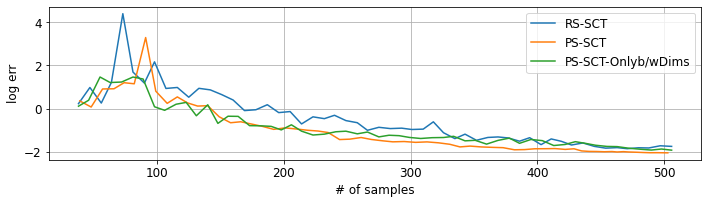

In [34]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=[10,3])
plt.plot(nf_RS[1:], np.log10(err_logRS)[1:],label='RS-SCT')
plt.plot(nf_PS[1:], np.log10(err_logPS)[1:],label='PS-SCT')
plt.plot(nf_PS2[1:], np.log10(err_logPS2)[1:],label='PS-SCT-Onlyb/wDims')
plt.ylabel('log err')
plt.xlabel('# of samples')
plt.legend()
plt.tight_layout()
plt.grid()
#plt.savefig('plots/cardiac_lc_permutation.png',dpi=300)
plt.show()

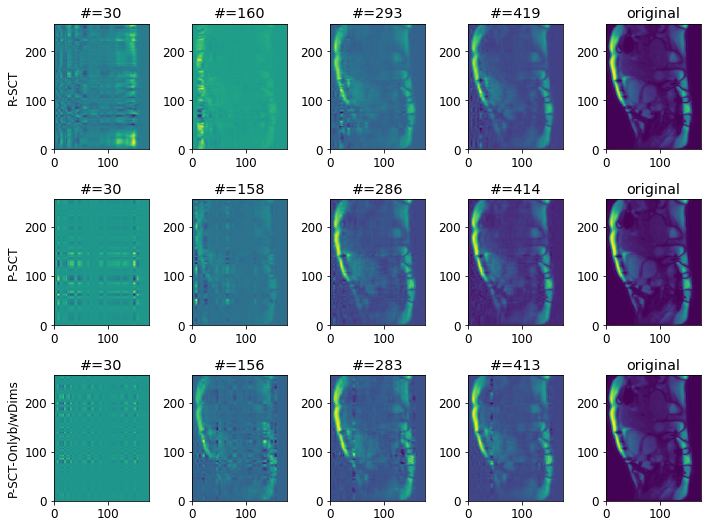

In [36]:
plt.rcParams.update({'font.size': 12})
f, ax = plt.subplots(3,5,figsize=[10,7.5])

ax[0,0].pcolormesh(Ahat(N,logRS_0[0],logRS_1[0],logRS_2[0])[:,:,0])
ax[0,1].pcolormesh(Ahat(N,logRS_0[15],logRS_1[15],logRS_2[15])[:,:,0])
ax[0,2].pcolormesh(Ahat(N,logRS_0[30],logRS_1[30],logRS_2[30])[:,:,0])
ax[0,3].pcolormesh(Ahat(N,logRS_0[45],logRS_1[45],logRS_2[45])[:,:,0])

ax[0,0].set_title('#=' + str(nf_RS[0]))
ax[0,1].set_title('#=' + str(nf_RS[15]))
ax[0,2].set_title('#=' + str(nf_RS[30]))
ax[0,3].set_title('#=' + str(nf_RS[45]))

ax[1,0].pcolormesh(Ahat(N,logPS_0[0],logPS_1[0],logPS_2[0])[:,:,0])
ax[1,1].pcolormesh(Ahat(N,logPS_0[15],logPS_1[15],logPS_2[15])[:,:,0])
ax[1,2].pcolormesh(Ahat(N,logPS_0[30],logPS_1[30],logPS_2[30])[:,:,0])
ax[1,3].pcolormesh(Ahat(N,logPS_0[45],logPS_1[45],logPS_2[45])[:,:,0])

ax[1,0].set_title('#=' + str(nf_PS[0]))
ax[1,1].set_title('#=' + str(nf_PS[15]))
ax[1,2].set_title('#=' + str(nf_PS[30]))
ax[1,3].set_title('#=' + str(nf_PS[45]))

ax[2,0].pcolormesh(Ahat(N,logPS2_0[0],logPS2_1[0],logPS2_2[0])[:,:,0])
ax[2,1].pcolormesh(Ahat(N,logPS2_0[15],logPS2_1[15],logPS2_2[15])[:,:,0])
ax[2,2].pcolormesh(Ahat(N,logPS2_0[30],logPS2_1[30],logPS2_2[30])[:,:,0])
ax[2,3].pcolormesh(Ahat(N,logPS2_0[45],logPS2_1[45],logPS2_2[45])[:,:,0])

ax[2,0].set_title('#=' + str(nf_PS2[0]))
ax[2,1].set_title('#=' + str(nf_PS2[15]))
ax[2,2].set_title('#=' + str(nf_PS2[30]))
ax[2,3].set_title('#=' + str(nf_PS2[45]))

ax[0,0].set_ylabel('R-SCT')
ax[1,0].set_ylabel('P-SCT')
ax[2,0].set_ylabel('P-SCT-Onlyb/wDims')

ax[0,4].pcolormesh(A[:,:,0])
ax[1,4].pcolormesh(A[:,:,0])
ax[2,4].pcolormesh(A[:,:,0])
ax[0,4].set_title('original')
ax[1,4].set_title('original')
ax[2,4].set_title('original')

plt.tight_layout()
#plt.savefig('plots/cardiac_Ar_permutation.png',dpi=300)
plt.show()